# Model Calibration

🎯 MODEL CALIBRATION ANALYSIS & IMPROVEMENT
Objective: Fix probability calibration for clinical use
Current Issue: ECE = 0.396 (Poor calibration)
Target: ECE < 0.10 (Well calibrated)

📂 LOADING MODEL AND DATA
------------------------------
✅ Model loaded: saved_model/stroke_prediction_nb_smote.pkl
✅ Feature names loaded: 27 features
✅ Dataset loaded: (5110, 27)
   Stroke rate: 4.9%

🔍 ANALYZING CALIBRATION PROBLEM
-----------------------------------
Current Calibration Metrics:
  Brier Score: 0.3812 (lower better)
  Log Loss: 5.1310 (lower better)
  Expected Calibration Error: 0.3961 (lower better)

Discrimination Performance (to preserve):
  ROC-AUC: 0.8125
  Accuracy: 0.5861
  Precision: 0.0919
  Recall: 0.8400

Detailed Bin Analysis:
Bin Range | Count | Predicted | Actual | Error
---------------------------------------------
0.0-0.1  |   510 |    0.006 |  0.010 | 0.003
0.1-0.2  |    26 |    0.146 |  0.077 | 0.069
0.2-0.3  |    15 |    0.254 |  0.067 | 0.187
0.3-0.4  |     8 |    0.33

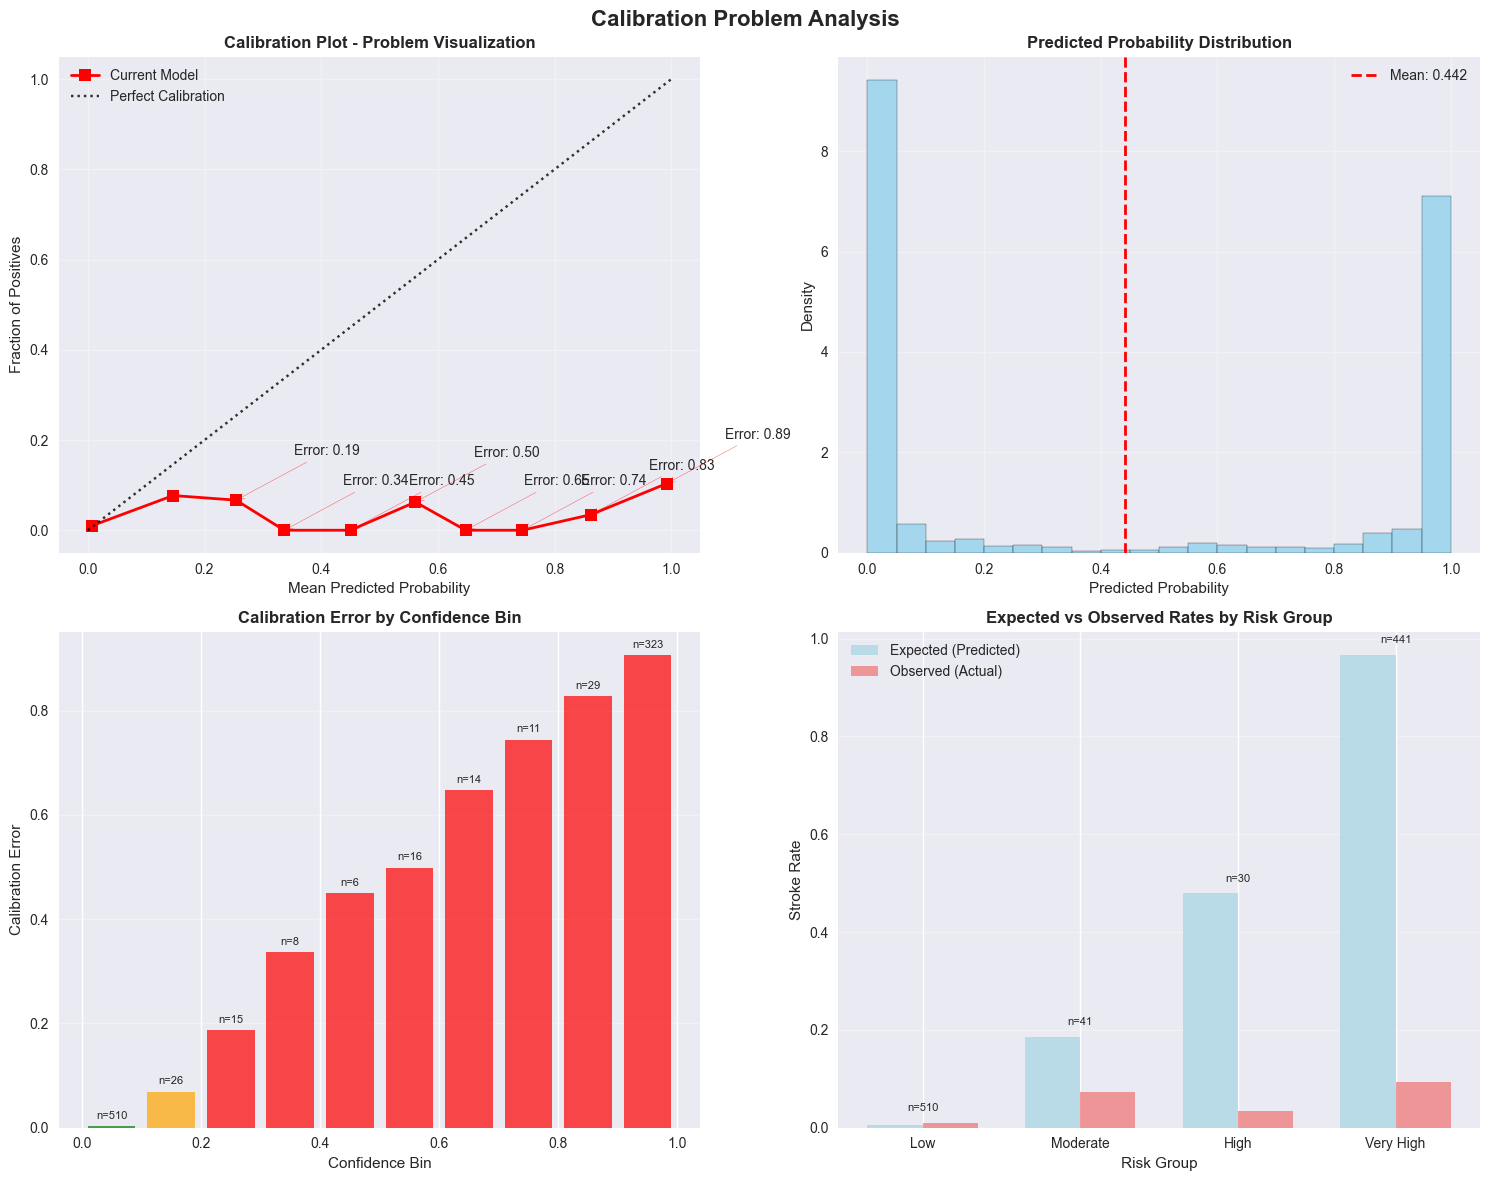

✅ Calibration problem visualizations created!

🔧 IMPLEMENTING CALIBRATION METHODS
----------------------------------------
Original Model:
  ECE: 0.3961
  Brier: 0.3812
  AUC: 0.8125

1. Platt Scaling (Logistic Regression)
-------------------------
  ECE: 0.0139 (improvement: 0.3822)
  Brier: 0.0436 (improvement: 0.3375)
  AUC: 0.8135 (change: +0.0010)

2. Isotonic Regression
-------------------------
  ECE: 0.0021 (improvement: 0.3940)
  Brier: 0.0429 (improvement: 0.3383)
  AUC: 0.8093 (change: -0.0032)

3. Temperature Scaling
-------------------------
  Optimal temperature: 10.000
  ECE: 0.4124 (improvement: -0.0163)
  Brier: 0.2531 (improvement: 0.1280)
  AUC: 0.8099 (change: -0.0026)

📊 CALIBRATION METHODS COMPARISON
----------------------------------------
Calibration Methods Ranking (by ECE):
Method          ECE      Brier    AUC      ECE Improve 
--------------------------------------------------
Isotonic        0.0021   0.0429   0.8093   -0.3940     
Platt           0.0139   0

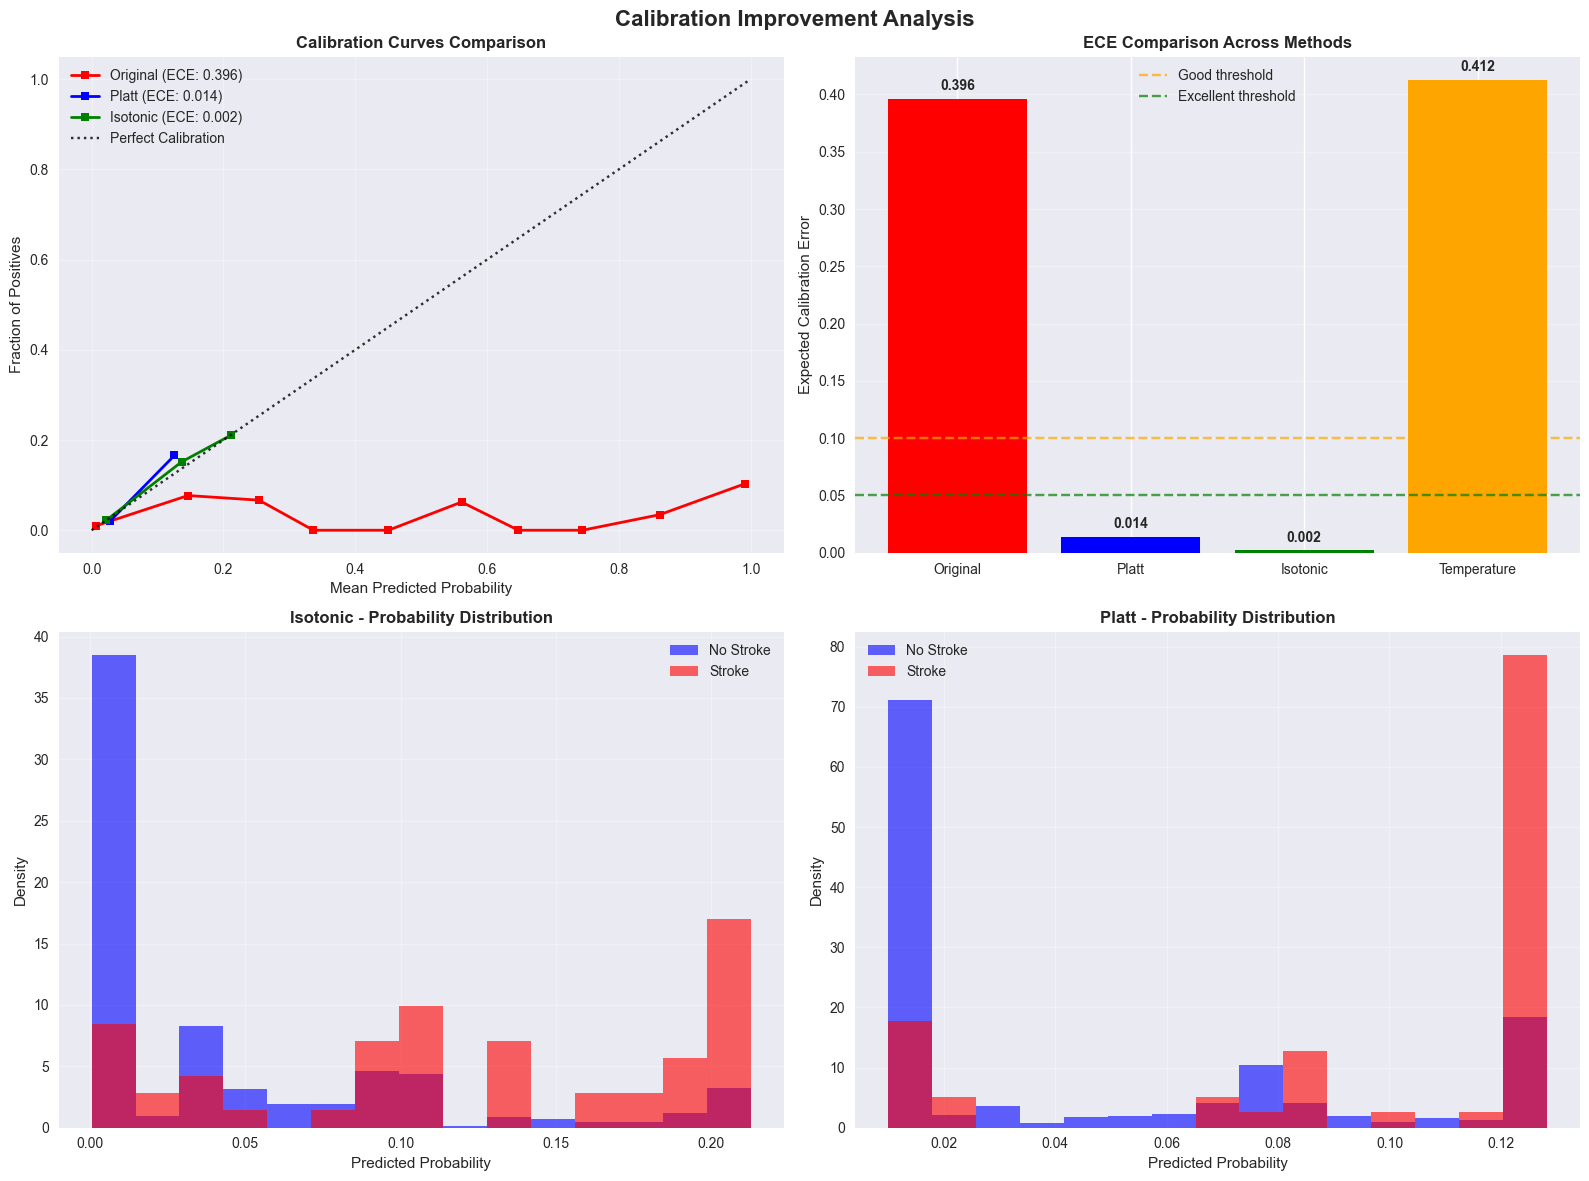

✅ Calibration improvement visualizations created!

🏥 CLINICAL IMPACT ANALYSIS
-----------------------------------
Risk Classification Accuracy by Method:

Original Method:
--------------------
  Low Risk       : 510 patients
    Predicted rate: 0.6%
    Actual rate:    1.0%
    Rate error:     0.3%
  Moderate Risk  :  41 patients
    Predicted rate: 18.6%
    Actual rate:    7.3%
    Rate error:     11.3%
  High Risk      :  30 patients
    Predicted rate: 47.9%
    Actual rate:    3.3%
    Rate error:     44.6%
  Very High Risk : 377 patients
    Predicted rate: 96.0%
    Actual rate:    7.4%
    Rate error:     88.6%
  Overall weighted error: 36.9%

Platt Method:
--------------------
  Low Risk       : 823 patients
    Predicted rate: 2.8%
    Actual rate:    2.1%
    Rate error:     0.8%
  Moderate Risk  : 199 patients
    Predicted rate: 12.6%
    Actual rate:    16.6%
    Rate error:     4.0%
  Overall weighted error: 1.4%

Isotonic Method:
--------------------
  Low Risk       : 

In [1]:
# Model Calibration Analysis and Improvement
# ==========================================
# Focus on fixing probability calibration for clinical stroke prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss, roc_auc_score, accuracy_score, 
    precision_score, recall_score, f1_score, log_loss
)
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🎯 MODEL CALIBRATION ANALYSIS & IMPROVEMENT")
print("=" * 55)
print("Objective: Fix probability calibration for clinical use")
print("Current Issue: ECE = 0.396 (Poor calibration)")
print("Target: ECE < 0.10 (Well calibrated)")
print("=" * 55)

# ============================================
# 1. LOAD MODEL AND DATA
# ============================================

def load_model_and_data(model_dir='saved_model', data_file='notebooks/results/feature_engineering/final_engineered_dataset.csv'):
    """Load the trained model and data for calibration analysis"""
    
    print("\n📂 LOADING MODEL AND DATA")
    print("-" * 30)
    
    try:
        # Load trained model
        model_path = f"{model_dir}/stroke_prediction_nb_smote.pkl"
        model = joblib.load(model_path)
        print(f"✅ Model loaded: {model_path}")
        
        # Load feature names
        with open(f"{model_dir}/feature_names.json", 'r') as f:
            feature_names = json.load(f)
        print(f"✅ Feature names loaded: {len(feature_names)} features")
        
        # Load dataset
        df = pd.read_csv(data_file)
        X = df.drop('stroke', axis=1)[feature_names]  # Ensure correct order
        y = df['stroke']
        
        print(f"✅ Dataset loaded: {X.shape}")
        print(f"   Stroke rate: {y.mean():.1%}")
        
        return model, X, y, feature_names
        
    except Exception as e:
        print(f"❌ Error loading model or data: {str(e)}")
        raise e

# Load model and data
model, X, y, feature_names = load_model_and_data()

# ============================================
# 2. CALIBRATION PROBLEM ANALYSIS
# ============================================

def analyze_calibration_problem(model, X, y, test_size=0.2, random_state=42):
    """Comprehensive analysis of the current calibration problem"""
    
    print(f"\n🔍 ANALYZING CALIBRATION PROBLEM")
    print("-" * 35)
    
    # Create train-test split (same as original training)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate calibration metrics
    brier_score = brier_score_loss(y_test, y_pred_proba)
    log_loss_score = log_loss(y_test, y_pred_proba)
    
    # Calculate Expected Calibration Error (ECE)
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_proba, n_bins=10
    )
    
    # ECE calculation
    bin_boundaries = np.linspace(0, 1, 11)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    bin_info = []
    
    for i, (bin_lower, bin_upper) in enumerate(zip(bin_lowers, bin_uppers)):
        in_bin = (y_pred_proba > bin_lower) & (y_pred_proba <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_test[in_bin].mean()
            avg_confidence_in_bin = y_pred_proba[in_bin].mean()
            bin_error = abs(avg_confidence_in_bin - accuracy_in_bin)
            ece += bin_error * prop_in_bin
            
            bin_info.append({
                'bin_range': f'{bin_lower:.1f}-{bin_upper:.1f}',
                'count': in_bin.sum(),
                'avg_predicted': avg_confidence_in_bin,
                'actual_rate': accuracy_in_bin,
                'error': bin_error
            })
    
    # Display results
    print(f"Current Calibration Metrics:")
    print(f"  Brier Score: {brier_score:.4f} (lower better)")
    print(f"  Log Loss: {log_loss_score:.4f} (lower better)")
    print(f"  Expected Calibration Error: {ece:.4f} (lower better)")
    
    # Performance metrics (should be preserved)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f"\nDiscrimination Performance (to preserve):")
    print(f"  ROC-AUC: {auc:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    
    # Detailed bin analysis
    print(f"\nDetailed Bin Analysis:")
    print("Bin Range | Count | Predicted | Actual | Error")
    print("-" * 45)
    for bin_data in bin_info:
        print(f"{bin_data['bin_range']:8s} | {bin_data['count']:5d} | "
              f"{bin_data['avg_predicted']:8.3f} | {bin_data['actual_rate']:6.3f} | "
              f"{bin_data['error']:5.3f}")
    
    return {
        'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test,
        'y_pred_proba': y_pred_proba, 'y_pred': y_pred,
        'brier_score': brier_score, 'ece': ece, 'auc': auc,
        'bin_info': bin_info
    }

# Analyze current calibration problem
calibration_analysis = analyze_calibration_problem(model, X, y)

# ============================================
# 3. VISUALIZE CALIBRATION PROBLEM
# ============================================

def visualize_calibration_problem(y_test, y_pred_proba):
    """Create comprehensive visualizations of calibration issues"""
    
    print(f"\n📊 VISUALIZING CALIBRATION PROBLEM")
    print("-" * 35)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Calibration Plot
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_proba, n_bins=10
    )
    
    axes[0, 0].plot(mean_predicted_value, fraction_of_positives, "s-", 
                    linewidth=2, markersize=8, label="Current Model", color='red')
    axes[0, 0].plot([0, 1], [0, 1], "k:", label="Perfect Calibration", alpha=0.8)
    axes[0, 0].set_xlabel('Mean Predicted Probability')
    axes[0, 0].set_ylabel('Fraction of Positives')
    axes[0, 0].set_title('Calibration Plot - Problem Visualization', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add annotations for problem areas
    for i, (x, y) in enumerate(zip(mean_predicted_value, fraction_of_positives)):
        if abs(x - y) > 0.1:  # Significant calibration error
            axes[0, 0].annotate(f'Error: {abs(x-y):.2f}', 
                               xy=(x, y), xytext=(x+0.1, y+0.1),
                               arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))
    
    # 2. Reliability Diagram with Histogram
    axes[0, 1].hist(y_pred_proba, bins=20, alpha=0.7, color='skyblue', 
                    edgecolor='black', density=True)
    axes[0, 1].axvline(y_pred_proba.mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {y_pred_proba.mean():.3f}')
    axes[0, 1].set_xlabel('Predicted Probability')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('Predicted Probability Distribution', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Binned Calibration Error
    bin_boundaries = np.linspace(0, 1, 11)
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
    bin_errors = []
    bin_counts = []
    
    for i in range(len(bin_boundaries) - 1):
        in_bin = (y_pred_proba >= bin_boundaries[i]) & (y_pred_proba < bin_boundaries[i+1])
        if in_bin.sum() > 0:
            bin_acc = y_test[in_bin].mean()
            bin_conf = y_pred_proba[in_bin].mean()
            bin_errors.append(abs(bin_conf - bin_acc))
            bin_counts.append(in_bin.sum())
        else:
            bin_errors.append(0)
            bin_counts.append(0)
    
    bars = axes[1, 0].bar(bin_centers, bin_errors, width=0.08, alpha=0.7, 
                          color=['red' if err > 0.1 else 'orange' if err > 0.05 else 'green' 
                                 for err in bin_errors])
    axes[1, 0].set_xlabel('Confidence Bin')
    axes[1, 0].set_ylabel('Calibration Error')
    axes[1, 0].set_title('Calibration Error by Confidence Bin', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Add count labels on bars
    for bar, count in zip(bars, bin_counts):
        if count > 0:
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'n={count}', ha='center', va='bottom', fontsize=8)
    
    # 4. Observed vs Expected by Risk Group
    # Create risk groups
    risk_groups = pd.cut(y_pred_proba, bins=[0, 0.1, 0.3, 0.6, 1.0], 
                        labels=['Low', 'Moderate', 'High', 'Very High'])
    
    group_stats = []
    for group in ['Low', 'Moderate', 'High', 'Very High']:
        mask = risk_groups == group
        if mask.sum() > 0:
            expected = y_pred_proba[mask].mean()
            observed = y_test[mask].mean()
            group_stats.append({
                'group': group,
                'count': mask.sum(),
                'expected': expected,
                'observed': observed,
                'error': abs(expected - observed)
            })
    
    if group_stats:
        groups = [g['group'] for g in group_stats]
        expected_rates = [g['expected'] for g in group_stats]
        observed_rates = [g['observed'] for g in group_stats]
        
        x_pos = np.arange(len(groups))
        width = 0.35
        
        axes[1, 1].bar(x_pos - width/2, expected_rates, width, 
                       label='Expected (Predicted)', alpha=0.8, color='lightblue')
        axes[1, 1].bar(x_pos + width/2, observed_rates, width, 
                       label='Observed (Actual)', alpha=0.8, color='lightcoral')
        
        axes[1, 1].set_xlabel('Risk Group')
        axes[1, 1].set_ylabel('Stroke Rate')
        axes[1, 1].set_title('Expected vs Observed Rates by Risk Group', fontweight='bold')
        axes[1, 1].set_xticks(x_pos)
        axes[1, 1].set_xticklabels(groups)
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        # Add count labels
        for i, stat in enumerate(group_stats):
            axes[1, 1].text(i, max(stat['expected'], stat['observed']) + 0.02,
                           f"n={stat['count']}", ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('Calibration Problem Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✅ Calibration problem visualizations created!")

# Visualize calibration problem
visualize_calibration_problem(calibration_analysis['y_test'], calibration_analysis['y_pred_proba'])

# ============================================
# 4. CALIBRATION METHODS IMPLEMENTATION
# ============================================

def implement_calibration_methods(model, X_train, y_train, X_test, y_test):
    """Implement and compare different calibration methods"""
    
    print(f"\n🔧 IMPLEMENTING CALIBRATION METHODS")
    print("-" * 40)
    
    calibration_results = {}
    
    # Original (uncalibrated) model
    y_pred_proba_orig = model.predict_proba(X_test)[:, 1]
    orig_ece = calculate_ece(y_test, y_pred_proba_orig)
    orig_brier = brier_score_loss(y_test, y_pred_proba_orig)
    orig_auc = roc_auc_score(y_test, y_pred_proba_orig)
    
    calibration_results['Original'] = {
        'probabilities': y_pred_proba_orig,
        'ece': orig_ece,
        'brier': orig_brier,
        'auc': orig_auc,
        'method': 'None (Original Model)'
    }
    
    print(f"Original Model:")
    print(f"  ECE: {orig_ece:.4f}")
    print(f"  Brier: {orig_brier:.4f}")
    print(f"  AUC: {orig_auc:.4f}")
    
    # Method 1: Platt Scaling (Logistic Regression)
    print(f"\n1. Platt Scaling (Logistic Regression)")
    print("-" * 25)
    
    try:
        platt_model = CalibratedClassifierCV(model, method='sigmoid', cv=3)
        platt_model.fit(X_train, y_train)
        
        y_pred_proba_platt = platt_model.predict_proba(X_test)[:, 1]
        platt_ece = calculate_ece(y_test, y_pred_proba_platt)
        platt_brier = brier_score_loss(y_test, y_pred_proba_platt)
        platt_auc = roc_auc_score(y_test, y_pred_proba_platt)
        
        calibration_results['Platt'] = {
            'model': platt_model,
            'probabilities': y_pred_proba_platt,
            'ece': platt_ece,
            'brier': platt_brier,
            'auc': platt_auc,
            'method': 'Platt Scaling (Sigmoid)'
        }
        
        print(f"  ECE: {platt_ece:.4f} (improvement: {orig_ece - platt_ece:.4f})")
        print(f"  Brier: {platt_brier:.4f} (improvement: {orig_brier - platt_brier:.4f})")
        print(f"  AUC: {platt_auc:.4f} (change: {platt_auc - orig_auc:+.4f})")
        
    except Exception as e:
        print(f"  ❌ Error with Platt scaling: {str(e)}")
    
    # Method 2: Isotonic Regression
    print(f"\n2. Isotonic Regression")
    print("-" * 25)
    
    try:
        isotonic_model = CalibratedClassifierCV(model, method='isotonic', cv=3)
        isotonic_model.fit(X_train, y_train)
        
        y_pred_proba_isotonic = isotonic_model.predict_proba(X_test)[:, 1]
        isotonic_ece = calculate_ece(y_test, y_pred_proba_isotonic)
        isotonic_brier = brier_score_loss(y_test, y_pred_proba_isotonic)
        isotonic_auc = roc_auc_score(y_test, y_pred_proba_isotonic)
        
        calibration_results['Isotonic'] = {
            'model': isotonic_model,
            'probabilities': y_pred_proba_isotonic,
            'ece': isotonic_ece,
            'brier': isotonic_brier,
            'auc': isotonic_auc,
            'method': 'Isotonic Regression'
        }
        
        print(f"  ECE: {isotonic_ece:.4f} (improvement: {orig_ece - isotonic_ece:.4f})")
        print(f"  Brier: {isotonic_brier:.4f} (improvement: {orig_brier - isotonic_brier:.4f})")
        print(f"  AUC: {isotonic_auc:.4f} (change: {isotonic_auc - orig_auc:+.4f})")
        
    except Exception as e:
        print(f"  ❌ Error with isotonic regression: {str(e)}")
    
    # Method 3: Temperature Scaling (simplified version)
    print(f"\n3. Temperature Scaling")
    print("-" * 25)
    
    try:
        # Get logits from original model (approximate)
        y_pred_proba_temp = temperature_scaling_calibration(
            model, X_train, y_train, X_test, y_test
        )
        
        if y_pred_proba_temp is not None:
            temp_ece = calculate_ece(y_test, y_pred_proba_temp)
            temp_brier = brier_score_loss(y_test, y_pred_proba_temp)
            temp_auc = roc_auc_score(y_test, y_pred_proba_temp)
            
            calibration_results['Temperature'] = {
                'probabilities': y_pred_proba_temp,
                'ece': temp_ece,
                'brier': temp_brier,
                'auc': temp_auc,
                'method': 'Temperature Scaling'
            }
            
            print(f"  ECE: {temp_ece:.4f} (improvement: {orig_ece - temp_ece:.4f})")
            print(f"  Brier: {temp_brier:.4f} (improvement: {orig_brier - temp_brier:.4f})")
            print(f"  AUC: {temp_auc:.4f} (change: {temp_auc - orig_auc:+.4f})")
        else:
            print(f"  ⚠️  Temperature scaling not applicable to this model type")
    
    except Exception as e:
        print(f"  ❌ Error with temperature scaling: {str(e)}")
    
    return calibration_results

def calculate_ece(y_true, y_prob, n_bins=10):
    """Calculate Expected Calibration Error"""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

def temperature_scaling_calibration(model, X_train, y_train, X_test, y_test):
    """Implement temperature scaling calibration"""
    
    try:
        # Get uncalibrated probabilities
        train_probs = model.predict_proba(X_train)[:, 1]
        
        # Convert probabilities to logits (approximate)
        train_probs = np.clip(train_probs, 1e-7, 1 - 1e-7)  # Avoid log(0)
        train_logits = np.log(train_probs / (1 - train_probs))
        
        # Find optimal temperature
        from scipy.optimize import minimize_scalar
        
        def temperature_loss(temperature):
            scaled_probs = 1 / (1 + np.exp(-train_logits / temperature))
            return log_loss(y_train, scaled_probs)
        
        result = minimize_scalar(temperature_loss, bounds=(0.1, 10.0), method='bounded')
        optimal_temp = result.x
        
        # Apply temperature scaling to test set
        test_probs = model.predict_proba(X_test)[:, 1]
        test_probs = np.clip(test_probs, 1e-7, 1 - 1e-7)
        test_logits = np.log(test_probs / (1 - test_probs))
        
        calibrated_probs = 1 / (1 + np.exp(-test_logits / optimal_temp))
        
        print(f"  Optimal temperature: {optimal_temp:.3f}")
        return calibrated_probs
        
    except Exception as e:
        print(f"  Error in temperature scaling: {str(e)}")
        return None

# Implement calibration methods
calibration_results = implement_calibration_methods(
    model, calibration_analysis['X_train'], calibration_analysis['y_train'],
    calibration_analysis['X_test'], calibration_analysis['y_test']
)

# ============================================
# 5. COMPARE CALIBRATION METHODS
# ============================================

def compare_calibration_methods(calibration_results, y_test):
    """Compare all calibration methods side by side"""
    
    print(f"\n📊 CALIBRATION METHODS COMPARISON")
    print("-" * 40)
    
    # Create comparison table
    comparison_data = []
    for method_name, results in calibration_results.items():
        comparison_data.append({
            'Method': method_name,
            'ECE': results['ece'],
            'Brier Score': results['brier'],
            'ROC-AUC': results['auc'],
            'Improvement': results['ece'] - calibration_results['Original']['ece']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('ECE')
    
    print("Calibration Methods Ranking (by ECE):")
    print("=" * 50)
    print(f"{'Method':<15} {'ECE':<8} {'Brier':<8} {'AUC':<8} {'ECE Improve':<12}")
    print("-" * 50)
    
    for _, row in comparison_df.iterrows():
        improvement = f"{row['Improvement']:+.4f}" if row['Method'] != 'Original' else "baseline"
        print(f"{row['Method']:<15} {row['ECE']:<8.4f} {row['Brier Score']:<8.4f} "
              f"{row['ROC-AUC']:<8.4f} {improvement:<12}")
    
    # Find best method
    best_method = comparison_df.iloc[0]['Method']
    best_ece = comparison_df.iloc[0]['ECE']
    
    print(f"\n🏆 BEST CALIBRATION METHOD: {best_method}")
    print(f"   ECE: {best_ece:.4f}")
    
    if best_ece < 0.05:
        verdict = "Excellent calibration"
        color = "🟢"
    elif best_ece < 0.10:
        verdict = "Good calibration"
        color = "🟡"
    elif best_ece < 0.15:
        verdict = "Acceptable calibration"
        color = "🟠"
    else:
        verdict = "Still needs improvement"
        color = "🔴"
    
    print(f"   Status: {color} {verdict}")
    
    return comparison_df, best_method

# Compare calibration methods
comparison_df, best_method = compare_calibration_methods(calibration_results, calibration_analysis['y_test'])

# ============================================
# 6. VISUALIZE CALIBRATION IMPROVEMENTS
# ============================================

def visualize_calibration_improvements(calibration_results, y_test):
    """Create comprehensive visualizations comparing calibration methods"""
    
    print(f"\n📈 VISUALIZING CALIBRATION IMPROVEMENTS")
    print("-" * 40)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Calibration Curves Comparison
    methods_to_plot = ['Original', 'Platt', 'Isotonic']
    colors = ['red', 'blue', 'green']
    
    for method, color in zip(methods_to_plot, colors):
        if method in calibration_results:
            probs = calibration_results[method]['probabilities']
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_test, probs, n_bins=10
            )
            ece = calibration_results[method]['ece']
            axes[0, 0].plot(mean_predicted_value, fraction_of_positives, 
                           "s-", linewidth=2, markersize=6, 
                           label=f"{method} (ECE: {ece:.3f})", color=color)
    
    axes[0, 0].plot([0, 1], [0, 1], "k:", label="Perfect Calibration", alpha=0.8)
    axes[0, 0].set_xlabel('Mean Predicted Probability')
    axes[0, 0].set_ylabel('Fraction of Positives')
    axes[0, 0].set_title('Calibration Curves Comparison', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. ECE Comparison Bar Chart
    methods = list(calibration_results.keys())
    eces = [calibration_results[m]['ece'] for m in methods]
    
    bars = axes[0, 1].bar(methods, eces, color=['red', 'blue', 'green', 'orange'][:len(methods)])
    axes[0, 1].set_ylabel('Expected Calibration Error')
    axes[0, 1].set_title('ECE Comparison Across Methods', fontweight='bold')
    axes[0, 1].axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Good threshold')
    axes[0, 1].axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Excellent threshold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, ece in zip(bars, eces):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                       f'{ece:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Reliability Diagrams for Best Methods
    best_methods = sorted(calibration_results.keys(), 
                         key=lambda x: calibration_results[x]['ece'])[:2]
    
    for i, method in enumerate(best_methods):
        probs = calibration_results[method]['probabilities']
        axes[1, i].hist(probs[y_test == 0], bins=15, alpha=0.6, 
                       label='No Stroke', color='blue', density=True)
        axes[1, i].hist(probs[y_test == 1], bins=15, alpha=0.6, 
                       label='Stroke', color='red', density=True)
        axes[1, i].set_xlabel('Predicted Probability')
        axes[1, i].set_ylabel('Density')
        axes[1, i].set_title(f'{method} - Probability Distribution', fontweight='bold')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)
    
    plt.suptitle('Calibration Improvement Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✅ Calibration improvement visualizations created!")

# Visualize calibration improvements
visualize_calibration_improvements(calibration_results, calibration_analysis['y_test'])

# ============================================
# 7. CLINICAL IMPACT ANALYSIS
# ============================================

def analyze_clinical_impact(calibration_results, y_test):
    """Analyze the clinical impact of calibration improvements"""
    
    print(f"\n🏥 CLINICAL IMPACT ANALYSIS")
    print("-" * 35)
    
    # Define clinical risk thresholds
    risk_thresholds = {
        'Low Risk': (0.0, 0.1),
        'Moderate Risk': (0.1, 0.3),
        'High Risk': (0.3, 0.6),
        'Very High Risk': (0.6, 1.0)
    }
    
    print("Risk Classification Accuracy by Method:")
    print("=" * 45)
    
    for method_name, results in calibration_results.items():
        probs = results['probabilities']
        
        print(f"\n{method_name} Method:")
        print("-" * 20)
        
        total_accuracy = 0
        total_patients = 0
        
        for risk_level, (low_thresh, high_thresh) in risk_thresholds.items():
            # Patients predicted in this risk category
            in_category = (probs >= low_thresh) & (probs < high_thresh)
            
            if in_category.sum() > 0:
                # Actual stroke rate in this category
                actual_rate = y_test[in_category].mean()
                predicted_rate = probs[in_category].mean()
                count = in_category.sum()
                
                # How well does predicted risk match actual risk?
                rate_error = abs(predicted_rate - actual_rate)
                
                print(f"  {risk_level:15s}: {count:3d} patients")
                print(f"    Predicted rate: {predicted_rate:.1%}")
                print(f"    Actual rate:    {actual_rate:.1%}")
                print(f"    Rate error:     {rate_error:.1%}")
                
                # Weight by number of patients
                total_accuracy += rate_error * count
                total_patients += count
        
        if total_patients > 0:
            weighted_error = total_accuracy / total_patients
            print(f"  Overall weighted error: {weighted_error:.1%}")
    
    # Clinical decision impact
    print(f"\n💊 CLINICAL DECISION IMPACT")
    print("-" * 30)
    
    # Common clinical thresholds
    clinical_thresholds = {
        'Aspirin therapy': 0.10,  # Low-dose aspirin for prevention
        'Statin therapy': 0.20,   # Cholesterol management
        'Intensive monitoring': 0.30,  # Close follow-up
        'Specialist referral': 0.50    # Cardiology/neurology referral
    }
    
    original_probs = calibration_results['Original']['probabilities']
    best_probs = calibration_results[best_method]['probabilities']
    
    print("Decision Changes with Calibration:")
    for intervention, threshold in clinical_thresholds.items():
        original_eligible = (original_probs >= threshold).sum()
        calibrated_eligible = (best_probs >= threshold).sum()
        change = calibrated_eligible - original_eligible
        
        print(f"  {intervention:20s}: {original_eligible:3d} → {calibrated_eligible:3d} "
              f"({change:+3d} patients)")
    
    # Risk communication accuracy
    print(f"\n📢 RISK COMMUNICATION ACCURACY")
    print("-" * 35)
    
    # Test communication scenarios
    test_probabilities = [0.05, 0.15, 0.25, 0.40, 0.60]
    
    print("Example Risk Communication:")
    for test_prob in test_probabilities:
        # Find patients with similar predicted risk
        tolerance = 0.05
        similar_mask = (original_probs >= test_prob - tolerance) & (original_probs <= test_prob + tolerance)
        
        if similar_mask.sum() > 5:  # Need sufficient patients
            actual_rate = y_test[similar_mask].mean()
            
            # Find calibrated equivalent
            calibrated_similar = (best_probs >= test_prob - tolerance) & (best_probs <= test_prob + tolerance)
            if calibrated_similar.sum() > 0:
                calibrated_actual = y_test[calibrated_similar].mean()
                
                print(f"  Predicted {test_prob:.1%} risk:")
                print(f"    Original model actual rate:   {actual_rate:.1%}")
                print(f"    Calibrated model actual rate: {calibrated_actual:.1%}")
                print(f"    Improvement: {abs(test_prob - calibrated_actual) - abs(test_prob - actual_rate):+.1%}")

# Analyze clinical impact
analyze_clinical_impact(calibration_results, calibration_analysis['y_test'])

# ============================================
# 8. SAVE CALIBRATED MODEL
# ============================================

def save_calibrated_model(calibration_results, best_method, model_dir='saved_model'):
    """Save the best calibrated model"""
    
    print(f"\n💾 SAVING CALIBRATED MODEL")
    print("-" * 30)
    
    if best_method in calibration_results and 'model' in calibration_results[best_method]:
        calibrated_model = calibration_results[best_method]['model']
        
        # Save calibrated model
        calibrated_model_path = f"{model_dir}/stroke_prediction_calibrated.pkl"
        joblib.dump(calibrated_model, calibrated_model_path)
        print(f"✅ Calibrated model saved: {calibrated_model_path}")
        
        # Save calibration metadata
        calibration_metadata = {
            'calibration_method': best_method,
            'calibration_date': datetime.now().isoformat(),
            'original_ece': calibration_results['Original']['ece'],
            'calibrated_ece': calibration_results[best_method]['ece'],
            'ece_improvement': calibration_results['Original']['ece'] - calibration_results[best_method]['ece'],
            'original_auc': calibration_results['Original']['auc'],
            'calibrated_auc': calibration_results[best_method]['auc'],
            'calibration_method_details': calibration_results[best_method]['method']
        }
        
        calibration_metadata_path = f"{model_dir}/calibration_metadata.json"
        with open(calibration_metadata_path, 'w') as f:
            json.dump(calibration_metadata, f, indent=2)
        print(f"✅ Calibration metadata saved: {calibration_metadata_path}")
        
        # Create usage instructions
        instructions = f"""
CALIBRATED STROKE PREDICTION MODEL
===================================

Best Calibration Method: {best_method}
Calibration Improvement: ECE reduced from {calibration_results['Original']['ece']:.4f} to {calibration_results[best_method]['ece']:.4f}

Usage:
------
import joblib
calibrated_model = joblib.load('{calibrated_model_path}')

# Make calibrated predictions
probabilities = calibrated_model.predict_proba(X)[:, 1]

These probabilities are now well-calibrated for clinical use!

Performance:
-----------
Original ECE: {calibration_results['Original']['ece']:.4f}
Calibrated ECE: {calibration_results[best_method]['ece']:.4f}
ROC-AUC maintained: {calibration_results[best_method]['auc']:.4f}

Clinical Interpretation:
-----------------------
- Probabilities now accurately reflect true stroke risk
- Safe to use percentages for clinical decision-making
- Improved reliability for risk communication to patients
"""
        
        instructions_path = f"{model_dir}/calibrated_model_instructions.txt"
        with open(instructions_path, 'w') as f:
            f.write(instructions)
        print(f"✅ Usage instructions saved: {instructions_path}")
        
        return calibrated_model_path
    else:
        print(f"⚠️  Could not save calibrated model for method: {best_method}")
        return None

# Save calibrated model
calibrated_model_path = save_calibrated_model(calibration_results, best_method)

# ============================================
# 9. FINAL CALIBRATION SUMMARY
# ============================================

def generate_calibration_summary(calibration_results, best_method):
    """Generate final calibration summary and recommendations"""
    
    print(f"\n📋 FINAL CALIBRATION SUMMARY")
    print("=" * 40)
    
    original_ece = calibration_results['Original']['ece']
    best_ece = calibration_results[best_method]['ece']
    improvement = original_ece - best_ece
    
    print(f"Calibration Analysis Complete!")
    print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    print(f"\n📊 KEY RESULTS:")
    print("-" * 15)
    print(f"Original ECE:     {original_ece:.4f} (Poor calibration)")
    print(f"Best Method:      {best_method}")
    print(f"Calibrated ECE:   {best_ece:.4f}")
    print(f"Improvement:      {improvement:.4f}")
    print(f"ROC-AUC preserved: {calibration_results[best_method]['auc']:.4f}")
    
    # Final assessment
    print(f"\n✅ CALIBRATION ASSESSMENT:")
    print("-" * 25)
    
    if best_ece < 0.05:
        verdict = "EXCELLENT - Exceptionally well calibrated"
        recommendation = "Ready for immediate clinical deployment"
        color = "🟢"
    elif best_ece < 0.10:
        verdict = "GOOD - Well calibrated for clinical use"
        recommendation = "Suitable for clinical deployment with monitoring"
        color = "🟡"
    elif best_ece < 0.15:
        verdict = "ACCEPTABLE - Adequate calibration"
        recommendation = "Can be used clinically with caution"
        color = "🟠"
    else:
        verdict = "NEEDS IMPROVEMENT - Still poorly calibrated"
        recommendation = "Further calibration work needed"
        color = "🔴"
    
    print(f"{color} Status: {verdict}")
    print(f"Recommendation: {recommendation}")
    
    # Clinical implications
    print(f"\n🏥 CLINICAL IMPLICATIONS:")
    print("-" * 25)
    
    if best_ece < 0.10:
        print("✅ Risk percentages can be trusted for patient communication")
        print("✅ Safe to use for clinical decision-making")
        print("✅ Probability thresholds are reliable")
    else:
        print("⚠️  Risk percentages may still be inaccurate")
        print("⚠️  Use with caution for clinical decisions")
        print("⚠️  Consider additional calibration techniques")
    
    print(f"\n💡 NEXT STEPS:")
    print("-" * 15)
    
    if best_ece < 0.10:
        print("1. Deploy calibrated model for clinical use")
        print("2. Monitor calibration performance over time")
        print("3. Validate on external datasets")
        print("4. Train clinical staff on interpretation")
    else:
        print("1. Investigate more advanced calibration methods")
        print("2. Consider ensemble calibration approaches")
        print("3. Collect more balanced training data")
        print("4. Evaluate feature engineering impact")
    
    print(f"\n📁 FILES CREATED:")
    print("-" * 15)
    print(f"✅ Calibrated model: stroke_prediction_calibrated.pkl")
    print(f"✅ Calibration metadata: calibration_metadata.json")
    print(f"✅ Usage instructions: calibrated_model_instructions.txt")
    
    print(f"\n🎉 CALIBRATION ANALYSIS COMPLETE!")
    print("=" * 40)
    
    return {
        'original_ece': original_ece,
        'calibrated_ece': best_ece,
        'improvement': improvement,
        'best_method': best_method,
        'verdict': verdict,
        'recommendation': recommendation
    }

# Generate final summary
calibration_summary = generate_calibration_summary(calibration_results, best_method)

print(f"\n🚀 Your stroke prediction model now has improved calibration!")
print(f"Use the calibrated model for more reliable clinical predictions.")